In [56]:
import csv
import pandas as pd
from datetime import datetime
from Levenshtein import distance as levenshtein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from fitter import Fitter
import itertools
import multiprocessing
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import shapiro
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

In [57]:
events_final = pd.read_csv('truncated_events_final_threeday.csv') 
print(events_final)

       patientid             events            starttime
0       10002013              CSURG  2160-05-18 01:49:32
1       10002013                ABG  2160-05-18 09:19:00
2       10002013                CBC  2160-05-18 09:19:00
3       10002013            Calcium  2160-05-18 09:19:00
4       10002013       Electrolytes  2160-05-18 09:19:00
...          ...                ...                  ...
96243   19995790            Glucose  2185-02-04 04:45:00
96244   19995790      Urea Nitrogen  2185-02-04 04:45:00
96245   19995790         Metoprolol  2185-02-04 20:00:00
96246   19995790  Magnesium Sulfate  2185-02-05 01:00:00
96247   19995790                 SW  2185-02-05 01:00:00

[96248 rows x 3 columns]


In [58]:

events_final['starttime'] = pd.to_datetime(events_final['starttime'])

In the next step, we will start to generat the trace

In [59]:

traces = events_final.groupby('patientid')['events'].apply(list).reset_index()
traces['starttimes'] = events_final.groupby('patientid')['starttime'].apply(list).reset_index(drop=True)

In [60]:
print(traces.head())
traces.to_csv('traces.csv', index=False)

   patientid                                             events  \
0   10002013  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
1   10011398  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
2   10023771  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
3   10033786  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   
4   10039688  [CSURG, ABG, CBC, Calcium, Electrolytes, Gluco...   

                                          starttimes  
0  [2160-05-18 01:49:32, 2160-05-18 09:19:00, 216...  
1  [2146-12-15 04:53:55, 2146-12-15 07:52:00, 214...  
2  [2113-08-25 03:17:43, 2113-08-25 07:29:00, 211...  
3  [2118-01-16 06:35:16, 2118-01-16 12:00:00, 211...  
4  [2147-05-31 02:31:44, 2147-05-31 07:57:00, 214...  


In [61]:
print(traces['events'].dtype)

object


In [62]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])

['CSURG', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'Aspirin', 'ABG', 'CBC', 'Electrolytes', 'Glucose', '5% Dextrose', 'Acetaminophen', 'Calcium Gluconate', 'Dextrose 50%', 'Glycopyrrolate', 'Influenza Vaccine', 'Insulin', 'Lactated Ringers', 'Magnesium Sulfate', 'Metoclopramide', 'Milk of Magnesia', 'Neostigmine', 'Nitroglycerin', 'Opioid', 'Oxycodone-Acetaminophen', 'PHENYLEPHrine', 'Pneumococcal Vaccine', 'Potassium Chloride', 'Propofol', 'Sodium Chloride 0.9%', 'Sodium Chloride 0.9%  Flush', 'Sterile Water', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'CBC', 'CefazoLIN', 'Sodium Chloride 0.9%', 'Bicarbonate', 'CBC', 'Creatinine', 'Electrolytes', 'Urea Nitrogen', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'Ketorolac', 'ABG', 'Electrolytes', 'Glucose', 'CBC', 'Electrolytes', 'Ondansetron', 'Albumin', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Li

In [63]:
def calculate_hamming_distance(list1, list2, pad_value=None):

    max_len = max(len(list1), len(list2))
    list1_padded = list1 + [pad_value] * (max_len - len(list1))
    list2_padded = list2 + [pad_value] * (max_len - len(list2))
    

    distance = sum(el1 != el2 for el1, el2 in zip(list1_padded, list2_padded))
    return distance

In [64]:

list1 = ['A','B','C','D']
list2 =['A','C','D']


hamming_distance_example = calculate_hamming_distance(list1, list2, pad_value='')
print(f"Hamming distance between list1 and list2: {hamming_distance_example}")

levenshtein_distance_example = levenshtein_distance(list1, list2)
print(f"levenshtein distance between list1 and list2: {levenshtein_distance_example}")

Hamming distance between list1 and list2: 3
levenshtein distance between list1 and list2: 1


In [65]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])
print(len(traces.iloc[1]['events']))
print(len(traces.iloc[2]['events']))
hamming_distance_1_2 = calculate_hamming_distance(first_line, second_line)
levenshtein_distance_1_2 = levenshtein_distance(first_line, second_line)
print(f"Hamming distance between the first and second lines: {hamming_distance_1_2}")
print(f"Levenshtein distance between the first and second lines: {levenshtein_distance_1_2}")

['CSURG', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'CBC', 'Electrolytes', 'Glucose', 'Aspirin', 'ABG', 'CBC', 'Electrolytes', 'Glucose', '5% Dextrose', 'Acetaminophen', 'Calcium Gluconate', 'Dextrose 50%', 'Glycopyrrolate', 'Influenza Vaccine', 'Insulin', 'Lactated Ringers', 'Magnesium Sulfate', 'Metoclopramide', 'Milk of Magnesia', 'Neostigmine', 'Nitroglycerin', 'Opioid', 'Oxycodone-Acetaminophen', 'PHENYLEPHrine', 'Pneumococcal Vaccine', 'Potassium Chloride', 'Propofol', 'Sodium Chloride 0.9%', 'Sodium Chloride 0.9%  Flush', 'Sterile Water', 'ABG', 'CBC', 'Calcium', 'Electrolytes', 'Glucose', 'CBC', 'CefazoLIN', 'Sodium Chloride 0.9%', 'Bicarbonate', 'CBC', 'Creatinine', 'Electrolytes', 'Urea Nitrogen', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'ABG', 'Calcium', 'Electrolytes', 'Glucose', 'Ketorolac', 'ABG', 'Electrolytes', 'Glucose', 'CBC', 'Electrolytes', 'Ondansetron', 'Albumin', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Li

In [66]:
num_elements = len(traces)
hamming_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))
for i in range(num_elements):
    for j in range(num_elements):
        hamming_distance = calculate_hamming_distance(traces.at[i, "events"], traces.at[j, "events"])
        hamming_distance_matrix.at[i, j] = hamming_distance

print(hamming_distance_matrix)

     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
0      0  106  110  110  107  108   99  115  114  117  ...   98  115  107   
1    106    0  102  102  101  104  100   90   98   95  ...  108   94  101   
2    110  102    0  108  114  104  113  119  106  103  ...  114  113  106   
3    110  102  108    0  104  107   90  108   93  119  ...  117  110   99   
4    107  101  114  104    0  114   99  107  109  114  ...  116  105  107   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
842  104  113  112  101  111  105  108  110  114  121  ...  113  118   98   
843  104   96   99  101  102  113  102  108  113  115  ...  115  110  103   
844  107   98  106   99  104  113  103  106   76  113  ...  117  100   90   
845  119  110  117  111  110  117  113  109  100  120  ...  125  107  103   
846  115   94  120  101  110  106  104   70   84  101  ...  111   71  104   

     840  841  842  843  844  845  846  
0    124  119  104  104  107  119 

In [67]:

hamming_row_averages = hamming_distance_matrix.mean(axis=1)
print("Hamming row averages:")
print(hamming_row_averages)

Hamming row averages:
0      114.002361
1      107.940968
2      113.752066
3      109.748524
4      109.374262
          ...    
842    114.593861
843    110.742621
844    105.343566
845    111.417946
846    107.688312
Length: 847, dtype: object


In [68]:

hamming_sorted_row_averages = hamming_row_averages.sort_values(ascending=False)
hamming_reordered_matrix = hamming_distance_matrix.loc[hamming_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(hamming_sorted_row_averages)

print("Reordered Hamming distance matrix:")
print(hamming_reordered_matrix)

Sorted row averages (descending):
333     200.81464
80     177.621015
460    169.144038
395    167.396694
52     165.229044
          ...    
439    104.031877
563    104.015348
627    103.995277
735    103.922078
340    103.538371
Length: 847, dtype: object
Reordered Hamming distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  193  199  196  200  200  201  183  205  207  206  ...  198  204  199   
80   179  183  176  174  182  179  177  184  184  181  ...  179  185  180   
460  164  155  170  175  174  172  170  167  173  165  ...  166  154  171   
395  167  165  168  160  172  171  167  163  164  169  ...  163  167  161   
52   164  167  161  159  166  172  167  175  175  173  ...  168  167  171   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
439  113   99  106  105   95  112  106  103   91  107  ...  115   92   98   
563  110   99  101  104  100  116  107  104   78  105  ...  120   96   99   
627  109   98

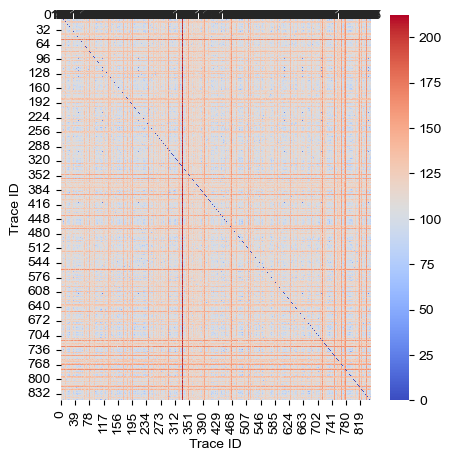

In [69]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Hamming Distance Matrix(72hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure1_Heatmap of Hamming Distance Matrix(72hour).png', format='png', dpi=300)
plt.show()

In [70]:
levenshtein_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        dist = levenshtein_distance(traces.at[i, "events"], traces.at[j, "events"])
        levenshtein_distance_matrix.at[i, j] = dist

print(levenshtein_distance_matrix)

    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840 841 842 843  \
0     0  53  60  49  72  62  66  48  45  67  ...  62  62  48  84  95  67  61   
1    53   0  59  58  62  68  70  35  33  58  ...  61  55  58  70  87  71  69   
2    60  59   0  52  56  72  73  52  50  57  ...  44  70  67  78  97  76  74   
3    49  58  52   0  75  65  70  53  48  72  ...  60  66  50  83  89  68  63   
4    72  62  56  75   0  77  79  54  50  65  ...  63  55  75  63  88  82  79   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
842  67  71  76  68  82  56  60  72  70  75  ...  84  76  60  85  96   0  56   
843  61  69  74  63  79  52  53  70  70  75  ...  75  74  61  87  91  56   0   
844  50  41  58  52  45  69  76  35  34  57  ...  65  40  56  61  76  75  78   
845  93  83  97  87  82  91  90  84  77  95  ...  93  79  84  96  26  93  84   
846  48  38  55  48  61  66  76  36  28  53  ...  64  48  50  68  78  72  70   

    844 845 846  
0    50  93  48  
1  

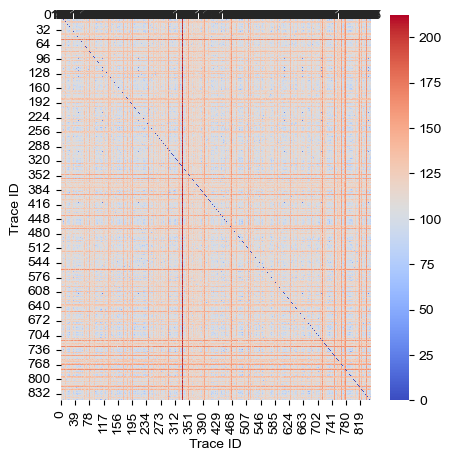

In [71]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Levenshtein Distance Matrix(72hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure2_Heatmap of Levenshtein Distance Matrix(72hour).png', format='png', dpi=300)
plt.show()

In [72]:

levenshtein_row_averages = levenshtein_distance_matrix.mean(axis=1)

print("Levenshtein row averages:")
print(levenshtein_row_averages)

Levenshtein row averages:
0      65.266824
1      63.760331
2      68.834711
3      68.113341
4      66.691854
         ...    
842    77.831169
843    73.249115
844    57.891381
845    87.194805
846    60.551358
Length: 847, dtype: object


In [73]:
levenshtein_averages = levenshtein_row_averages.tolist()
levenshtein_averages = pd.DataFrame(levenshtein_row_averages, columns=['variation distance'])

print("Levenshtein averages:")
print(levenshtein_averages)

Levenshtein averages:
    variation distance
0            65.266824
1            63.760331
2            68.834711
3            68.113341
4            66.691854
..                 ...
842          77.831169
843          73.249115
844          57.891381
845          87.194805
846          60.551358

[847 rows x 1 columns]


In [74]:

levenshtein_sorted_row_averages = levenshtein_row_averages.sort_values(ascending=False)


levenshtein_reordered_matrix = levenshtein_distance_matrix.loc[levenshtein_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(levenshtein_sorted_row_averages)

print("Reordered Levenshtein distance matrix:")
print(levenshtein_reordered_matrix)

Sorted row averages (descending):
333    143.272727
395      125.5549
80     117.571429
416    114.401417
460    113.812279
          ...    
810     57.442739
329      56.75915
734     56.736718
394     56.270366
497     56.144038
Length: 847, dtype: object
Reordered Levenshtein distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  129  146  134  131  149  138  133  147  144  134  ...  129  146  137   
395  125  129  122  131  118  125  124  130  128  131  ...  127  124  125   
80   107  118  106  115  115  111  111  115  114  103  ...  105  117  118   
416  106  106   98  113  114  119  119  107  107  106  ...   94  103  111   
460  101  116  101  105  120   98   99  113  117  110  ...  104  114  106   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
810   50   44   58   54   50   69   74   34   29   57  ...   61   43   50   
329   41   32   50   46   55   62   70   36   19   51  ...   58   51   46   
734   44 

In [75]:
temp_distance = levenshtein_sorted_row_averages.reset_index(drop=True)

top_2_5_percentile = np.percentile(temp_distance, 97.5)
top_5_percentile = np.percentile(temp_distance, 95)
top_10_percentile = np.percentile(temp_distance, 90)
top_20_percentile = np.percentile(temp_distance, 80)
bottom_20_percentile = np.percentile(temp_distance, 20)

print(f"Top 2.5% of the list is above: {top_2_5_percentile}")
print(f"22 th: {levenshtein_sorted_row_averages[21]}")
print(f"Top 5% of the list is above: {top_5_percentile}")
print(f"Top 10% of the list is above: {top_10_percentile}")
print(f"Top 20% of the list is above: {top_20_percentile}")
print(f"Bottom 20% of the list is below: {bottom_20_percentile}")

Top 2.5% of the list is above: 99.32739079102716
22 th: 62.00944510035419
Top 5% of the list is above: 91.00838252656433
Top 10% of the list is above: 84.83471074380165
Top 20% of the list is above: 78.72184179456907
Bottom 20% of the list is below: 64.28075560802834


In [76]:
if not levenshtein_sorted_row_averages.index.equals(hamming_sorted_row_averages.index):
    levenshtein_sorted_row_averages_positions = pd.Series(levenshtein_sorted_row_averages.index, name='levenshtein_sorted_row_averages_index')
    hamming_sorted_row_averages_positions = pd.Series(hamming_sorted_row_averages.index, name='hamming_sorted_row_averages_index')

    comparison_df = pd.DataFrame({'levenshtein_sorted_row_averages_position': levenshtein_sorted_row_averages_positions, 'hamming_sorted_row_averages_position': hamming_sorted_row_averages_positions})
    mismatched_positions = comparison_df[levenshtein_sorted_row_averages_positions != hamming_sorted_row_averages_positions]
    display(comparison_df)  
    print("Mismatched indexes and their positions:")
    display(mismatched_positions)  
else:
    print("Both DataFrames have the same index order.")

,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
0,333,333
1,395,80
2,80,460
3,416,395
4,460,52
...,...,...
842,810,439
843,329,563
844,734,627
845,394,735


Mismatched indexes and their positions:


,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
1,395,80
2,80,460
3,416,395
4,460,52
5,94,728
...,...,...
842,810,439
843,329,563
844,734,627
845,394,735


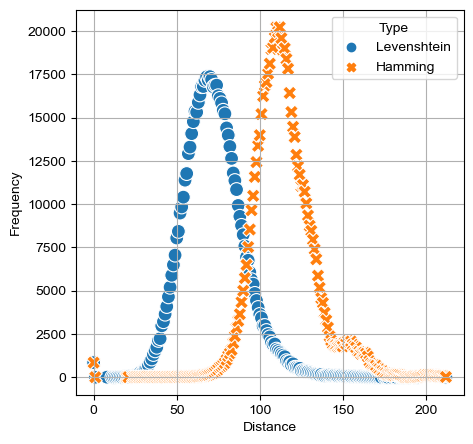

In [77]:
lev_distances = levenshtein_distance_matrix.values.flatten()
ham_distances = hamming_distance_matrix.values.flatten()

lev_unique_distances, lev_counts = np.unique(lev_distances, return_counts=True)
ham_unique_distances, ham_counts = np.unique(ham_distances, return_counts=True)

lev_distance_freq_df = pd.DataFrame({'Distance': lev_unique_distances, 'Frequency': lev_counts, 'Type': 'Levenshtein'})
ham_distance_freq_df = pd.DataFrame({'Distance': ham_unique_distances, 'Frequency': ham_counts, 'Type': 'Hamming'})

distance_freq_df = pd.concat([lev_distance_freq_df, ham_distance_freq_df])

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=distance_freq_df, x='Distance', y='Frequency', hue='Type', style='Type', s=100)

#plt.title('Frequency Distributions of Hamming and Levenshtein Distance Measurements(72hour)', fontsize=12, fontweight='bold')
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('eFigure3_Frequency Distributions of Hamming and Levenshtein Distance Measurements(72hour).png', bbox_inches='tight',format='png', dpi=300)
plt.grid(True)
plt.show()

In [78]:
#Select the top 2.5% and bottom 2.5% lists
top_2_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.025))
bottom_2_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.975))

top_2_percent_lists = levenshtein_reordered_matrix.iloc[:top_2_percent_index]
bottom_2_percent_lists = levenshtein_reordered_matrix.iloc[bottom_2_percent_index:]

In [79]:
# Select the top 5% and bottom 5% lists
top_5_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.05))
bottom_5_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.95))

top_5_percent_lists = levenshtein_reordered_matrix.iloc[:top_5_percent_index]
bottom_5_percent_lists = levenshtein_reordered_matrix.iloc[bottom_5_percent_index:]

In [80]:
# Select the top 10% and bottom 10% lists
top_10_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.10))
bottom_10_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.90))

top_10_percent_lists = levenshtein_reordered_matrix.iloc[:top_10_percent_index]
bottom_10_percent_lists = levenshtein_reordered_matrix.iloc[bottom_10_percent_index:]

In [81]:
# Select the top 20% and bottom 20% lists
top_20_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.20))
bottom_20_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.80))

top_20_percent_lists = levenshtein_reordered_matrix.iloc[:top_20_percent_index]
bottom_20_percent_lists = levenshtein_reordered_matrix.iloc[bottom_20_percent_index:]

In [82]:
print("Top 2.5% lists:")
print(top_2_percent_lists)
print("Bottom 2.5% lists:")
print(bottom_2_percent_lists)

top_2_percent_index = top_2_percent_lists.index.tolist()
print("PatientID of Top 2.5% traces:")
print(top_2_percent_lists.index.tolist())
bottom_2_percent_index = bottom_2_percent_lists.index.tolist()
print("PatientID of Bottom 2.5% traces:")
print(bottom_2_percent_lists.index.tolist())

Top 2.5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  129  146  134  131  149  138  133  147  144  134  ...  129  146  137   
395  125  129  122  131  118  125  124  130  128  131  ...  127  124  125   
80   107  118  106  115  115  111  111  115  114  103  ...  105  117  118   
416  106  106   98  113  114  119  119  107  107  106  ...   94  103  111   
460  101  116  101  105  120   98   99  113  117  110  ...  104  114  106   
94   119  111  121  112  112  119  113  109  100  123  ...  126  108  109   
299  118  110  121  111  112  118  114  109   99  123  ...  126  108  108   
467  107  116  113  106  113   99   98  120  118  112  ...  112  117   99   
170   94  110  101  101  109  103  102  110  105   99  ...  103  112  105   
645   98  105   94  101  110  101   94   97  101  101  ...  100  103  108   
52    98  105  103  105   89  111  110  102  103  100  ...   93  102  111   
816   95  109  101   94  110   92   94  109  108  100  ...  

In [83]:
complete_patients_clinical = pd.read_csv('completepatients.csv')
complete_patients = pd.concat([complete_patients_clinical,levenshtein_averages], axis=1)
print(complete_patients.head())

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  \
0         SINGLE                   1                         1  ...   
1        MARRIED                   0                         0  ...   
2        MARRIED                   0                         0  ...   
3        MARRIED                   0                         0  ...   
4        MARRIED                   1                         0  ...   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0          

In [84]:
#print(complete_patients.dtypes)
complete_patients['distance'] = pd.to_numeric(complete_patients['variation distance'], errors='coerce')

In [85]:
complete_patients['age_group'] = pd.cut(complete_patients['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                         labels=['20-30', '31-40', '41-50', '51-60', '61-70','71-80','81-90','91-100'])

In [86]:
def categorize_cci(cci):
    if 10 <= cci <= 12:
        return '10-12'
    elif 8 <= cci < 10:
        return '8-10'
    elif 6 <= cci < 8:
        return '6-8'
    elif 4 <= cci < 6:  
        return '4-6'
    elif 2 <= cci < 4:  
        return '2-4'
    elif 0 <= cci < 2:
        return '0-2'
complete_patients['cci_group'] = complete_patients['cci'].apply(categorize_cci)

In [87]:
def categorize_distance(distance):
    if distance >= 78.72:  
        return 'top20%'
    else:  
        return 'Other'
complete_patients['distance_group'] = complete_patients['distance'].apply(categorize_distance)

In [88]:
print(complete_patients.head())
#complete_patients.to_csv('test.csv',index = False)
value_counts = complete_patients['distance_group'].value_counts()
print(value_counts)

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  aids  \
0         SINGLE                   1                         1  ...     0   
1        MARRIED                   0                         0  ...     0   
2        MARRIED                   0                         0  ...     0   
3        MARRIED                   0                         0  ...     0   
4        MARRIED                   1                         0  ...     0   

   cci  in_hospital_mortality  died_within_30_days  length_of_stay  

In [89]:
complete_patients['race'] = complete_patients['race'].str.split(' ').str[0]
complete_patients['race']= complete_patients['race'].replace(['BLACK/AFRICAN', 'BLACK/CARIBBEAN','BLACK/CAPE','HISPANIC/LATINO','HISPANIC','PATIENT', 'UNABLE','SOUTH','PORTUGUESE','MULTIPLE','OTHER','ASIAN','UNKNOWN'], 'OTHER')
value_counts_race = complete_patients['race'].value_counts()
print(value_counts_race)

race
WHITE    667
OTHER    180
Name: count, dtype: int64


In [90]:
value_counts_gender = complete_patients['gender'].value_counts()
print(value_counts_gender)
value_counts_insurance = complete_patients['insurance'].value_counts()
print(value_counts_insurance)

gender
M    701
F    146
Name: count, dtype: int64
insurance
Other       506
Medicare    313
Medicaid     28
Name: count, dtype: int64


In [91]:
y = complete_patients['length_of_stay']
model = smf.ols('y ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)', data=complete_patients).fit()
print(model.summary())
residuals = model.resid
exog = model.model.exog
s, p = shapiro(residuals)
print('Shapiro-Wilk p:', p)
breuschpagan_test = het_breuschpagan(residuals, exog)
name = ['lm', 'lm_pvalue', 'fvalue', 'f_pvalue']
print(dict(zip(name, breuschpagan_test)))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     24.82
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           7.16e-31
Time:                        16:47:03   Log-Likelihood:                -4755.0
No. Observations:                 847   AIC:                             9526.
Df Residuals:                     839   BIC:                             9564.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [92]:
gamma_model = smf.glm(
    formula='length_of_stay ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)',
    data=complete_patients,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         length_of_stay   No. Observations:                  847
Model:                            GLM   Df Residuals:                      839
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.16214
Method:                          IRLS   Log-Likelihood:                -4411.3
Date:                Mon, 21 Jul 2025   Deviance:                       86.500
Time:                        16:47:03   Pearson chi2:                     136.
No. Iterations:                    13   Pseudo R-squ. (CS):             0.2187
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [93]:
np.exp(gamma_model.params)

Intercept                   145.589951
distance_group[T.top20%]      1.353311
C(gender)[T.M]                0.955496
C(insurance)[T.Medicare]      0.850973
C(insurance)[T.Other]         0.803707
C(race)[T.WHITE]              0.965152
age                           0.998863
cci                           1.057695
dtype: float64

In [94]:
np.exp(gamma_model.conf_int())

,0,1
Intercept,111.952843,189.333591
distance_group[T.top20%],1.261847,1.451406
C(gender)[T.M],0.888188,1.027904
C(insurance)[T.Medicare],0.724932,0.998928
C(insurance)[T.Other],0.688017,0.938849
C(race)[T.WHITE],0.901726,1.033039
age,0.995260,1.002480
cci,1.039593,1.076113


4.716879123196203e-31


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


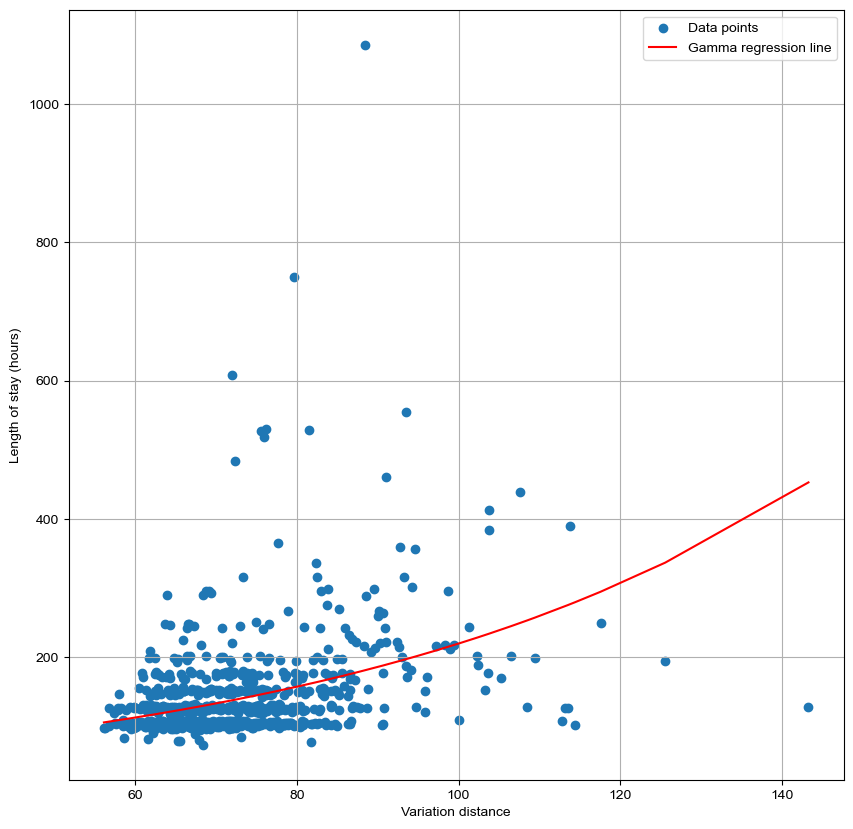

In [95]:
x = complete_patients['variation distance'].astype(float).values
#y = (complete_patients['length_of_stay'].astype(float) / 24).values

y = complete_patients['length_of_stay'].astype(float).values

X = sm.add_constant(x)

gamma_model = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
gamma_results = gamma_model.fit()


x_sorted = np.sort(x)
X_sorted = sm.add_constant(x_sorted)
y_pred = gamma_results.predict(X_sorted)


null_model = sm.GLM(y, np.ones((len(y), 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2 = 1 - gamma_results.deviance / null_model.deviance


p_value = gamma_results.pvalues[1]
print(p_value)

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x, y,label='Data points')
plt.plot(x_sorted, y_pred, color='red', label='Gamma regression line')

plt.xlabel('Variation distance', fontsize=10)
plt.ylabel('Length of stay (hours)', fontsize=10)
plt.grid(True)

plt.legend()
plt.savefig('Figure_Relationship Between Variation and Length of Stay(72-hour).png',
            bbox_inches='tight', format='png', dpi=800)
plt.show()

In [96]:
print(complete_patients.columns)

Index(['subject_id', 'hadm_id', 'age', 'gender', 'insurance', 'language',
       'race', 'marital_status', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'cci', 'in_hospital_mortality',
       'died_within_30_days', 'length_of_stay', 'variation distance',
       'distance', 'age_group', 'cci_group', 'distance_group'],
      dtype='object')


In [97]:
top_2_percent = complete_patients.loc[top_2_percent_index]
print(top_2_percent)
output_path = 'top_2_percent.csv'
top_2_percent.to_csv(output_path, index=False)
top_2_percent_los = top_2_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_2_percent_los}")
top_2_percent_in_hospital_mortality = top_2_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_2_percent_in_hospital_mortality}")
top_2_percent_30_day_mortality = top_2_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_2_percent_30_day_mortality}")
top_2_percent_cci =top_2_percent['cci'].mean()
print(f"The average of CCI is: {top_2_percent_cci}")
top_2_percent_top3cci_averages = top_2_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_2_percent_top3cci = top_2_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_2_percent_top3cci)

     subject_id   hadm_id  age gender insurance language   race  \
333    14195255  27013153   74      M  Medicare  ENGLISH  WHITE   
395    14908025  23478116   60      M     Other  ENGLISH  OTHER   
80     11076206  20326682   63      F  Medicare  ENGLISH  WHITE   
416    15156174  27191368   51      M     Other  ENGLISH  WHITE   
460    15610823  26657269   69      F  Medicare  ENGLISH  WHITE   
94     11162509  29912299   69      M     Other  ENGLISH  WHITE   
299    13963514  24742780   49      M     Other  ENGLISH  WHITE   
467    15708357  20482084   52      M  Medicare  ENGLISH  WHITE   
170    12253915  28119979   79      M  Medicare  ENGLISH  WHITE   
645    17641873  21705480   81      M     Other  ENGLISH  WHITE   
52     10710573  29923776   55      M  Medicaid        ?  OTHER   
816    19674244  28712211   55      M     Other  ENGLISH  WHITE   
358    14546527  22937328   66      M  Medicare  ENGLISH  OTHER   
349    14369707  20575513   75      F  Medicare  ENGLISH  WHIT

In [98]:
# Display the top 5% lists
print("Top 5% lists:")
print(top_5_percent_lists)

# Display the bottom 5% lists
print("Bottom 5% lists:")
print(bottom_5_percent_lists)

top_5_percent_index = top_5_percent_lists.index.tolist()
print("PatientID of Top 5% traces:")
print(top_5_percent_lists.index.tolist())
bottom_5_percent_index = bottom_5_percent_lists.index.tolist()
print("PatientID of Bottom 5% traces:")
print(bottom_5_percent_lists.index.tolist())

Top 5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  129  146  134  131  149  138  133  147  144  134  ...  129  146  137   
395  125  129  122  131  118  125  124  130  128  131  ...  127  124  125   
80   107  118  106  115  115  111  111  115  114  103  ...  105  117  118   
416  106  106   98  113  114  119  119  107  107  106  ...   94  103  111   
460  101  116  101  105  120   98   99  113  117  110  ...  104  114  106   
94   119  111  121  112  112  119  113  109  100  123  ...  126  108  109   
299  118  110  121  111  112  118  114  109   99  123  ...  126  108  108   
467  107  116  113  106  113   99   98  120  118  112  ...  112  117   99   
170   94  110  101  101  109  103  102  110  105   99  ...  103  112  105   
645   98  105   94  101  110  101   94   97  101  101  ...  100  103  108   
52    98  105  103  105   89  111  110  102  103  100  ...   93  102  111   
816   95  109  101   94  110   92   94  109  108  100  ...   9

In [99]:
# Display the top 10% lists
print("Top 10% lists:")
print(top_10_percent_lists)

# Display the bottom 10% lists
print("Bottom 10% lists:")
print(bottom_10_percent_lists)

top_10_percent_index = top_10_percent_lists.index.tolist()
print("PatientID of Top 10% traces:")
print(top_10_percent_lists.index.tolist())
bottom_10_percent_index = bottom_10_percent_lists.index.tolist()
print("PatientID of Bottom 10% traces:")
print(bottom_10_percent_lists.index.tolist())

Top 10% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  129  146  134  131  149  138  133  147  144  134  ...  129  146  137   
395  125  129  122  131  118  125  124  130  128  131  ...  127  124  125   
80   107  118  106  115  115  111  111  115  114  103  ...  105  117  118   
416  106  106   98  113  114  119  119  107  107  106  ...   94  103  111   
460  101  116  101  105  120   98   99  113  117  110  ...  104  114  106   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
404   90   90   80   89   72  100   95   84   82   84  ...   81   82   95   
478   87   91   89   82   88   87   83   87   82   94  ...   99   88   82   
273   75   71   79   72   89   73   80   75   70   78  ...   84   76   69   
761   72   85   80   71   86   66   78   86   82   84  ...   83   88   73   
424   72   83   78   73   88   54   78   83   75   83  ...   86   83   65   

     840  841  842  843  844  845  846  
333  146  187  137 

In [100]:
# Display the top 20% lists
print("Top 20% lists:")
print(top_20_percent_lists)

# Display the bottom 20% lists
print("Bottom 20% lists:")
print(bottom_20_percent_lists)

top_20_percent_index = top_20_percent_lists.index.tolist()
print("PatientID of Top 20% traces:")
print(top_20_percent_lists.index.tolist())
bottom_20_percent_index = bottom_20_percent_lists.index.tolist()
print("PatientID of Bottom 20% traces:")
print(bottom_20_percent_lists.index.tolist())

Top 20% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  129  146  134  131  149  138  133  147  144  134  ...  129  146  137   
395  125  129  122  131  118  125  124  130  128  131  ...  127  124  125   
80   107  118  106  115  115  111  111  115  114  103  ...  105  117  118   
416  106  106   98  113  114  119  119  107  107  106  ...   94  103  111   
460  101  116  101  105  120   98   99  113  117  110  ...  104  114  106   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
599   80   78   69   82   66   84   81   75   76   75  ...   73   68   85   
110   74   79   61   64   77   69   72   71   68   80  ...   69   82   75   
302   88   80   85   92   65   91   90   73   68   88  ...   84   72   91   
518   88   76   82   92   73   89   87   73   75   85  ...   83   70   92   
83    56   68   72   66   82   70   64   66   67   82  ...   74   81   55   

     840  841  842  843  844  845  846  
333  146  187  137 

In [101]:
top_5_percent = complete_patients.loc[top_5_percent_index]
output_path = 'top_5_percent.csv'
top_5_percent.to_csv(output_path, index=False)
top_5_percent_los = top_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_5_percent_los}")
top_5_percent_in_hospital_mortality = top_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_5_percent_in_hospital_mortality}")
top_5_percent_30_day_mortality = top_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_5_percent_30_day_mortality}")
top_5_percent_cci =top_5_percent['cci'].mean()
print(f"The average of CCI is: {top_5_percent_cci}")
top_5_percent_top3cci_averages = top_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_5_percent_top3cci = top_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_5_percent_top3cci)

The average of LOS is: 230.1468992248062
The average of in_hospital_mortality is: 0.06976744186046512
The average of 30_day_mortality is: 0.06976744186046512
The average of CCI is: 5.0
Top3 CCI:
congestive_heart_failure     0.348837
renal_disease                0.348837
chronic_pulmonary_disease    0.325581
dtype: float64


In [102]:
top_10_percent = complete_patients.loc[top_10_percent_index]
output_path = 'top_10_percent.csv'
top_10_percent.to_csv(output_path, index=False)
top_10_percent_los = top_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_10_percent_los}")
top_10_percent_in_hospital_mortality = top_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_10_percent_in_hospital_mortality}")
top_10_percent_30_day_mortality = top_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_10_percent_30_day_mortality}")
top_10_percent_cci =top_10_percent['cci'].mean()
print(f"The average of CCI is: {top_10_percent_cci}")
top_10_percent_top3cci_averages = top_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_10_percent_top3cci = top_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_10_percent_top3cci)

The average of LOS is: 215.46098039215684
The average of in_hospital_mortality is: 0.03529411764705882
The average of 30_day_mortality is: 0.03529411764705882
The average of CCI is: 4.752941176470588
Top3 CCI:
diabetes_without_cc    0.352941
renal_disease          0.329412
myocardial_infarct     0.305882
dtype: float64


In [103]:
top_20_percent = complete_patients.loc[top_20_percent_index]
output_path = 'top_20_percent.csv'
top_20_percent.to_csv(output_path, index=False)
top_20_percent_los = top_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_20_percent_los}")
top_20_percent_in_hospital_mortality = top_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_20_percent_in_hospital_mortality}")
top_20_percent_30_day_mortality = top_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_20_percent_30_day_mortality}")
top_20_percent_cci =top_20_percent['cci'].mean()
print(f"The average of CCI is: {top_20_percent_cci}")
top_20_percent_top3cci_averages = top_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_20_percent_top3cci = top_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_20_percent_top3cci)

The average of LOS is: 187.63460784313722
The average of in_hospital_mortality is: 0.023529411764705882
The average of 30_day_mortality is: 0.023529411764705882
The average of CCI is: 4.682352941176471
Top3 CCI:
diabetes_without_cc    0.405882
myocardial_infarct     0.305882
renal_disease          0.276471
dtype: float64


In [104]:
bottom_5_percent = complete_patients.loc[bottom_5_percent_index]
output_path = 'bottom_5_percent.csv'
bottom_5_percent.to_csv(output_path, index=False)
bottom_5_percent_los = bottom_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_5_percent_los}")
bottom_5_percent_in_hospital_mortality = bottom_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_5_percent_in_hospital_mortality}")
bottom_5_percent_30_day_mortality = bottom_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_5_percent_30_day_mortality}")
bottom_5_percent_cci =bottom_5_percent['cci'].mean()
print(f"The average of CCI is: {bottom_5_percent_cci}")

bottom_5_percent_top3cci_averages = bottom_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_5_percent_top3cci = bottom_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_5_percent_top3cci)

The average of LOS is: 109.5593023255814
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.0
Top3 CCI:
diabetes_without_cc         0.279070
myocardial_infarct          0.209302
congestive_heart_failure    0.139535
dtype: float64


In [105]:
bottom_10_percent = complete_patients.loc[bottom_10_percent_index]
output_path = 'bottom_10_percent.csv'
bottom_10_percent.to_csv(output_path, index=False)
bottom_10_percent_los = bottom_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_10_percent_los}")
bottom_10_percent_in_hospital_mortality = bottom_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_10_percent_in_hospital_mortality}")
bottom_10_percent_30_day_mortality = bottom_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_10_percent_30_day_mortality}")
bottom_10_percent_cci =bottom_10_percent['cci'].mean()
print(f"The average of CCI is: {bottom_10_percent_cci}")

bottom_10_percent_top3cci_averages = bottom_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_10_percent_top3cci = bottom_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_10_percent_top3cci)

The average of LOS is: 114.20549019607842
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 2.988235294117647
Top3 CCI:
diabetes_without_cc         0.305882
myocardial_infarct          0.152941
congestive_heart_failure    0.094118
dtype: float64


In [106]:
bottom_20_percent = complete_patients.loc[bottom_20_percent_index]
output_path = 'bottom_20_percent.csv'
bottom_20_percent.to_csv(output_path, index=False)
bottom_20_percent_los = bottom_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_20_percent_los}")
bottom_20_percent_in_hospital_mortality = bottom_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_20_percent_in_hospital_mortality}")
bottom_20_percent_30_day_mortality = bottom_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_20_percent_30_day_mortality}")
bottom_20_percent_cci =bottom_20_percent['cci'].mean()
print(f"The average of CCI is: {bottom_20_percent_cci}")

bottom_20_percent_top3cci_averages = bottom_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_20_percent_top3cci = bottom_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_20_percent_top3cci)

The average of LOS is: 117.95999999999998
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.0588235294117645
Top3 CCI:
diabetes_without_cc          0.311765
myocardial_infarct           0.182353
chronic_pulmonary_disease    0.105882
dtype: float64


In [107]:
#X = complete_patients[['age','cci','myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']]

In [108]:
traces_top_2_percent = traces.iloc[top_2_percent_index]
top_2_percent_patient = traces_top_2_percent['patientid']
print(top_2_percent_patient)
events_final_top_2_percent = events_final[events_final['patientid'].isin(top_2_percent_patient)]
print(events_final_top_2_percent)
events_final_top_2_percent.to_csv('events_final_top_2_percent.csv', index=False)

333    14195255
395    14908025
80     11076206
416    15156174
460    15610823
94     11162509
299    13963514
467    15708357
170    12253915
645    17641873
52     10710573
816    19674244
358    14546527
349    14369707
778    19359798
728    18669132
558    16688809
715    18477527
440    15417736
748    18942549
364    14603993
295    13801654
Name: patientid, dtype: int64
       patientid             events           starttime
5818    10710573              CSURG 2114-04-17 01:33:36
5819    10710573                ABG 2114-04-17 08:26:00
5820    10710573                CBC 2114-04-17 08:26:00
5821    10710573            Calcium 2114-04-17 08:26:00
5822    10710573       Electrolytes 2114-04-17 08:26:00
...          ...                ...                 ...
92898   19674244         Creatinine 2194-11-19 01:16:00
92899   19674244       Electrolytes 2194-11-19 01:16:00
92900   19674244            Glucose 2194-11-19 01:16:00
92901   19674244      Urea Nitrogen 2194-11-19 01:16:00
92

In [109]:
traces_top_5_percent = traces.iloc[top_5_percent_index]
top_5_percent_patient = traces_top_5_percent['patientid']
print(top_5_percent_patient)
events_final_top_5_percent = events_final[events_final['patientid'].isin(top_5_percent_patient)]
print(events_final_top_5_percent)
events_final_top_5_percent.to_csv('events_final_top_5_percent.csv', index=False)

333    14195255
395    14908025
80     11076206
416    15156174
460    15610823
94     11162509
299    13963514
467    15708357
170    12253915
645    17641873
52     10710573
816    19674244
358    14546527
349    14369707
778    19359798
728    18669132
558    16688809
715    18477527
440    15417736
748    18942549
364    14603993
295    13801654
835    19872834
240    13139482
121    11561996
231    12980551
513    16199860
100    11318805
607    17244760
393    14877104
383    14790760
411    15058789
179    12383901
468    15737972
767    19177655
821    19705462
651    17672672
213    12751607
661    17773753
611    17325365
519    16225290
114    11464841
406    14983135
Name: patientid, dtype: int64
       patientid        events           starttime
5818    10710573         CSURG 2114-04-17 01:33:36
5819    10710573           ABG 2114-04-17 08:26:00
5820    10710573           CBC 2114-04-17 08:26:00
5821    10710573       Calcium 2114-04-17 08:26:00
5822    10710573  Electroly

In [110]:
traces_bottom_20_percent = traces.iloc[bottom_20_percent_index]
bottom_20_percent_patient = traces_bottom_20_percent['patientid']
print(bottom_20_percent_patient)
events_final_bottom_20_percent = events_final[events_final['patientid'].isin(bottom_20_percent_patient)]
print(events_final_bottom_20_percent)
events_final_bottom_20_percent.to_csv('events_final_bottom_20_percent.csv', index=False)

430    15251348
248    13242149
674    17954027
621    17387845
183    12434305
         ...   
810    19628228
329    14166615
734    18716421
394    14884188
497    16019747
Name: patientid, Length: 170, dtype: int64
       patientid             events           starttime
119     10011398              CSURG 2146-12-15 04:53:55
120     10011398                ABG 2146-12-15 07:52:00
121     10011398                CBC 2146-12-15 07:52:00
122     10011398            Calcium 2146-12-15 07:52:00
123     10011398       Electrolytes 2146-12-15 07:52:00
...          ...                ...                 ...
96243   19995790            Glucose 2185-02-04 04:45:00
96244   19995790      Urea Nitrogen 2185-02-04 04:45:00
96245   19995790         Metoprolol 2185-02-04 20:00:00
96246   19995790  Magnesium Sulfate 2185-02-05 01:00:00
96247   19995790                 SW 2185-02-05 01:00:00

[17264 rows x 3 columns]
